# <center>Building an Image Classifier with Differential Privacy using Opacus</center>

Opacus is a library developed by Facebook AI Research that enables training PyTorch models with differential privacy. It helps in protecting the privacy of individual data points in training datasets by adding noise to gradients during the training process, ensuring that the models do not memorize sensitive information.



---

```py
pip install opacus
pip install torch
```

---

## Loading Dependencies

In [1]:
import opacus
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision.transforms import transforms
from torchvision.datasets import CIFAR10

import warnings
warnings.simplefilter("ignore")

## Overview

In this demo we will learn to do the following:
  1. Learn about privacy-specific hyper-parameters related to DP-SGD 
  2. Learn about ModelInspector, incompatible layers, and use model rewriting utility. 
  3. Train a differentially private ResNet18 for image classification.

----

## Helper Function

In [2]:
def set_seed(seed=None, seed_torch=True):
    """
    Function that controls randomness. NumPy and random modules must be imported.

    Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

    Returns:
    Nothing.
    """
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print(f'Random seed {seed} has been set.')
    

def set_device():
    """
    Set the device. CUDA if available, CPU otherwise
    Args: 
        None
    Returns: 
        Nothing
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("GPU is not enabled in this environment.")
        
    else:
        print("GPU is enabled in this environment.") 
    
    return device

In [3]:
set_seed(seed=42)

Random seed 42 has been set.


## Dataset

In [4]:
# Custom Data Transform

C10_MEAN = (0.4914, 0.4822, 0.4465)
C10_STD = (0.2023, 0.1994, 0.2010)

train_data = CIFAR10(root="./cifar10_data", 
                     train=True, 
                     download=True, 
                     transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(C10_MEAN, C10_STD)])
                    )

test_data = CIFAR10(root="./cifar10_data", 
                     train=False, 
                     download=True, 
                     transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(C10_MEAN, C10_STD)])
                    )

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Create DataLoaders

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

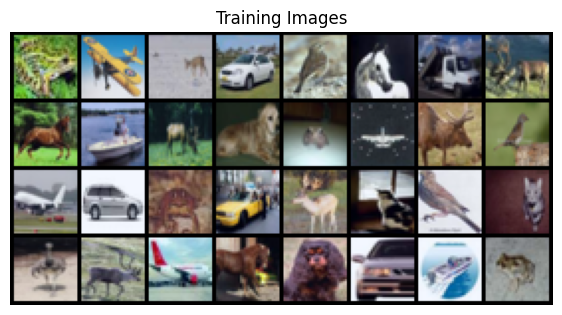

In [6]:
## A Quick Visual Check

for images, labels in train_dataloader:
    break

plt.figure(figsize=(7,7))
plt.imshow(np.transpose(a=torchvision.utils.make_grid(images[:64], padding=2, normalize=True), axes=(1, 2, 0)))
plt.axis('off')
plt.title("Training Images")
plt.show(); 

----

## Model

In [7]:
model = torch.hub.load("pytorch/vision", "resnet18", weights=None) 

Using cache found in /teamspace/studios/this_studio/.cache/torch/hub/pytorch_vision_main


Now, let’s check if the model is compatible with Opacus. Opacus does not support all types of Pytorch layers. To check if your model is compatible with the privacy engine, we have provided a util class to validate your model.

When you run the code below, you're presented with a list of errors, indicating which modules are incompatible.

In [8]:
from opacus.validators import ModuleValidator
errors = ModuleValidator.validate(model, strict=False)
errors[0] 

opacus.validators.errors.ShouldReplaceModuleError("BatchNorm cannot support training with differential privacy. The reason for it is that BatchNorm makes each sample's normalized value depend on its peers in a batch, ie the same sample x will get normalized to a different value depending on who else is on its batch. Privacy-wise, this means that we would have to put a privacy mechanism there too. While it can in principle be done, there are now multiple normalization layers that do not have this issue: LayerNorm, InstanceNorm and their generalization GroupNorm are all privacy-safe since they don't have this property.We offer utilities to automatically replace BatchNorms to GroupNorms and we will release pretrained models to help transition, such as GN-ResNet ie a ResNet using GroupNorm, pretrained on ImageNet")

In [9]:
# Running this code will make the ResNet model compactible with Opacus; by replacing the BatchNorm Layer with GroupNorm layer in the model.
model = ModuleValidator.fix(model)
ModuleValidator.validate(model, strict=False)

[]

```py
model #<--- To verify, run this on a code cell.
```

In [10]:
device = set_device()
model = model.to(device) #<--- move model to GPU (if available)

GPU is enabled in this environment.


## Training

### Privacy Specific Hyper-Parameters To Tune

To train a model with Opacus there are three privacy-specific hyper-parameters that must be tuned for better performance:

* Max Grad Norm: The maximum L2 norm of per-sample gradients before they are aggregated by the averaging step.
* Noise Multiplier: The amount of noise sampled and added to the average of the gradients in a batch.
* Delta: The target δ of the (ϵ,δ)-differential privacy guarantee. Generally, it should be set to be less than the inverse of the size of the training dataset. In this lab, it is set to $10^{−5}$ as the CIFAR10 dataset has 50,000 training points.

We use the hyper-parameter values below to obtain results in the last section:

In [11]:
MAX_GRAD_NORM = 1.2
EPSILON = 50.0
DELTA = 1e-5
EPOCHS = 100

LR = 1e-3

---

We then define our optimizer and loss function. Opacus’ privacy engine can attach to any (first-order) optimizer.  You can use your favorite&mdash;Adam, SGD, Adagrad, RMSprop&mdash;as long as it has an implementation derived from [torch.optim.Optimizer](https://pytorch.org/docs/stable/optim.html).

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [13]:
def accuracy(preds, labels):
    """
    A utility function to calculate accuracy
    """
    return (preds == labels).mean()

We now attach the privacy engine initialized with the privacy hyperparameters defined earlier.

In [14]:
from opacus import PrivacyEngine

privacy_engine = PrivacyEngine()

model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_dataloader,
    epochs=EPOCHS,
    target_epsilon=EPSILON,
    target_delta=DELTA,
    max_grad_norm=MAX_GRAD_NORM,
)

print(f"Using sigma={optimizer.noise_multiplier} and C={MAX_GRAD_NORM}")

Using sigma=0.3633880615234375 and C=1.2


---

There's another constraint we should be mindful of—memory. To balance peak memory requirement, which is proportional to batch_size^2, and training performance, we will be using BatchMemoryManager. It separates the logical batch size (which defines how often the model is updated and how much DP noise is added), and a physical batch size (which defines how many samples we process at a time).

With BatchMemoryManager you will create your DataLoader with a logical batch size, and then provide the maximum physical batch size to the memory manager.

In [15]:
BATCH_SIZE = 512
MAX_PHYSICAL_BATCH_SIZE = 128

---

We will then define our train function. This function will train the model for 20 epochs.

In [16]:
import numpy as np
from opacus.utils.batch_memory_manager import BatchMemoryManager


def train(model, train_loader, optimizer, epoch, device):
    model.train()
    criterion = nn.CrossEntropyLoss()

    losses = []
    top1_acc = []
    
    with BatchMemoryManager(
        data_loader=train_loader, 
        max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE, 
        optimizer=optimizer
    ) as memory_safe_data_loader:

        for i, (images, target) in enumerate(memory_safe_data_loader):   
            optimizer.zero_grad()
            images = images.to(device)
            target = target.to(device)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()

            # measure accuracy and record loss
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

            loss.backward()
            optimizer.step()

            if (i+1) % 200 == 0:
                epsilon = privacy_engine.get_epsilon(DELTA)
                print(
                    f"\tTrain Epoch: {epoch} \t"
                    f"Loss: {np.mean(losses):.6f} "
                    f"Acc@1: {np.mean(top1_acc) * 100:.6f} "
                    f"(ε = {epsilon:.2f}, δ = {DELTA})"
                )

Next, we will define our test function to validate our model on our test dataset.

In [17]:
def test(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    losses = []
    top1_acc = []

    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

    top1_avg = np.mean(top1_acc)

    print(
        f"\tTest set:"
        f"Loss: {np.mean(losses):.6f} "
        f"Acc: {top1_avg * 100:.6f} "
    )
    return np.mean(top1_acc)

## Train The Network

In [18]:
from tqdm.notebook import tqdm

for epoch in tqdm(range(EPOCHS), desc="Epoch", unit="epoch"):
    train(model, train_loader, optimizer, epoch + 1, device)

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]

	Train Epoch: 1 	Loss: 2.746559 Acc@1: 15.315586 (ε = 6.33, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.446326 Acc@1: 19.545879 (ε = 6.95, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.315118 Acc@1: 22.059358 (ε = 7.37, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.234289 Acc@1: 23.719535 (ε = 7.72, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.179285 Acc@1: 24.945079 (ε = 8.03, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.141599 Acc@1: 25.813732 (ε = 8.31, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.110472 Acc@1: 26.649543 (ε = 8.56, δ = 1e-05)
	Train Epoch: 2 	Loss: 1.913316 Acc@1: 31.915574 (ε = 8.98, δ = 1e-05)
	Train Epoch: 2 	Loss: 1.914628 Acc@1: 31.739502 (ε = 9.20, δ = 1e-05)
	Train Epoch: 2 	Loss: 1.910697 Acc@1: 31.887395 (ε = 9.40, δ = 1e-05)
	Train Epoch: 2 	Loss: 1.909986 Acc@1: 32.099759 (ε = 9.59, δ = 1e-05)
	Train Epoch: 2 	Loss: 1.907728 Acc@1: 32.303069 (ε = 9.78, δ = 1e-05)
	Train Epoch: 2 	Loss: 1.907108 Acc@1: 32.373250 (ε = 9.95, δ = 1e-05)
	Train Epoch: 2 	Loss: 1.898779 Acc@1: 32.625716 (ε = 10.12, δ = 1e-05)
	Trai

---
## Model Performance On Test Data

In [19]:
top1_acc = test(model, test_dataloader, device)

	Test set:Loss: 1.861222 Acc: 51.867013 


---

## Tips On Improving Model Performance

> - Generally speaking, differentially private training is enough of a regularizer by itself. Adding any more regularization (such as dropouts or data augmentation) is unnecessary and typically hurts performance.
> - Tuning `MAX_GRAD_NORM` is very important. Start with a low noise multiplier like 0.1, this should give comparable performance to a non-private model. Then do a grid search for the optimal `MAX_GRAD_NORM` value. The grid can be in the range [0.1, 10].
> - You can play around with the level of privacy, `EPSILON`. Smaller EPSILON means more privacy, more noise -- and hence lower accuracy. Reducing EPSILON to 5.0 reduces the Top 1 Accuracy. One useful technique is to pre-train a model on public (non-private) data, before completing the training on the private training data. See the workbook [here](bit.ly/opacus-dev-day) for an example.